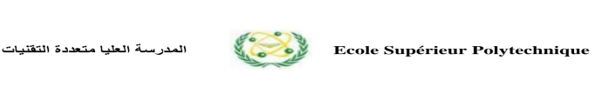

# I- Chargement

In [ ]:
import pandas as pd
df = pd.read_csv('file_names_mapping (2).csv')
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'file_names_mapping (2).csv'

In [ ]:

df['Age'] = df['Age'].replace('Unknown', 0)

df['Age'] = df['Age'].astype(int)

def age_to_group(age):
    if 13 <= age <= 19:
        return 'teens'
    elif 20 <= age <= 29:
        return 'twenties'
    elif 30 <= age <= 39:
        return 'thirties'
    elif 40 <= age <= 49:
        return 'forties'
    elif 50 <= age <= 59:
        return 'fifties'
    elif 60 <= age <= 69:
        return 'sixties'
    elif 70 <= age <= 79:
        return 'seventies'
    elif 80 <= age <= 89:
        return 'eighties'
    else:
        return 'unknown'

df['Age Group'] = df['Age'].apply(age_to_group)

print(df.head())

In [ ]:
def map_gender(gender):
    if gender.upper() == 'M':
        return 'male'
    elif gender.upper() == 'F' or gender.lower() == 'f':
        return 'female'
    else:
        return 'unknown'
df['Gender'] = df['Gender'].apply(map_gender)
print(df)

# II- Visualisation selon groupe d'âge

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(15, 5)})
sns.countplot(x="Age Group",
              data=df[df['Age'].notna()],
              order=['teens', 'twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies', 'eighties'])

plt.show()

Nous remarquons que l'age de la majorite de notre population est compris entre 20 et 29 ans. Ce qui est logique en fait parce que la pluspart des messages vocales sont ceux de nos collegues eleves ingenieur.

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
ds_path = "/content/drive/MyDrive/Vocal/"

# III- Extraire les caractéristiques des audios

In [ ]:
def feature_extraction(file_name):
    audio_data, sampling_rate = librosa.load(ds_path + file_name)
    features = []
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sampling_rate))
    features.extend([spectral_centroid, spectral_bandwidth, spectral_rolloff])

    mfcc = librosa.feature.mfcc(y=audio_data, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))

    return features



# 4 Création d'un DataFrame de caractéristiques audio

In [ ]:
# Create features dataframe
def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig) - 1
    stop_counter = 30000

    for idx, row in orig.iterrows():
        if idx >= stop_counter:
            break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)
        features = feature_extraction(row['New File Names'])
        features.append(row['Age Group'])
        features.append(row['Gender'])
        new_rows.append(features)

    return pd.DataFrame(new_rows, columns=["spectral_centroid", "spectral_bandwidth", "spectral_rolloff",
                                           "mfcc1", "mfcc2", "mfcc3", "mfcc4", "mfcc5", "mfcc6", "mfcc7", "mfcc8",
                                           "mfcc9", "mfcc10", "mfcc11", "mfcc12", "mfcc13", "mfcc14", "mfcc15", "mfcc16",
                                           "mfcc17", "mfcc18", "mfcc19", "mfcc20", "age_group", "gender"])

df_features = create_df_features(df)
print(df_features.head())

*La fonction feature_extraction prend un nom de fichier audio, charge les données audio, et extrait plusieurs caractéristiques importantes de l'audio :*

*Centroïde spectral : Indique le "centre de gravité" du spectre de fréquences.

*Largeur de bande spectrale : Mesure la dispersion des fréquences.

*Roll-off spectral : Indique la fréquence en dessous de laquelle se trouve une certaine proportion de l'énergie spectrale.

Coefficients MFCC : Caractéristiques couramment utilisées pour l'analyse de la voix.*
Ces caractéristiques sont retournes sous forme de liste. **

# 5 Normalisation des caractéristiques audio à l'aide de StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

def scale_features(df):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(np.array(df.iloc[:, 0:-2], dtype = float))

    return scaled_data, scaler

x, scaler = scale_features(df_features)
print("Before scaling:", df_features.iloc[0].values[:-2])
print("\nAfter scaling:", x[0])

# 6 Encodage des étiquettes d'âge et de sexe avec LabelEncoder

In [ ]:
# Encode labels
def get_labels(df1):
    age_labels = df1['age_group']
    gender_labels = df1['gender']

    age_encoder = LabelEncoder()
    gender_encoder = LabelEncoder()

    age_labels = age_encoder.fit_transform(age_labels)
    gender_labels = gender_encoder.fit_transform(gender_labels)

    return age_labels, gender_labels, age_encoder, gender_encoder

y_age, y_gender, age_encoder, gender_encoder = get_labels(df_features)
print("Age classes:", age_encoder.classes_)
print("Gender classes:", gender_encoder.classes_)

# 7 Modèle LSTM pour la prédiction de l'âge et du sexe à partir de données vocales

In [ ]:
y_age = to_categorical(y_age, num_classes=len(age_encoder.classes_))
y_gender = to_categorical(y_gender, num_classes=len(gender_encoder.classes_))


In [ ]:
# Prepare data for LSTM model
x = x.reshape(x.shape[0], x.shape[1], 1)

x_train, x_test, y_train_age, y_test_age, y_train_gender, y_test_gender = train_test_split(x, y_age, y_gender, test_size=0.2, random_state=42)



In [ ]:
# Build LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

1. *Construction du modèle LSTM* :
   - Vous utilisez un modèle séquentiel de Keras pour créer votre réseau neuronal.
   - La première couche LSTM contient 128 neurones et prend en entrée la forme (x_train.shape[1], x_train.shape[2]). Cela signifie que la forme de l'entrée pour chaque exemple de données est (nombre de caractéristiques, longueur de la séquence). Cette couche est configurée pour retourner les séquences complètes plutôt que seulement la dernière sortie à l'aide de return_sequences=True.
   - Ensuite, vous ajoutez une couche de régularisation Dropout avec un taux de dropout de 0.5, ce qui signifie qu'à chaque étape d'entraînement, chaque unité de la couche LSTM a une probabilité de 0.5 d'être mise à zéro de manière aléatoire, aidant ainsi à prévenir le surapprentissage.
   - Une deuxième couche LSTM est ajoutée avec 64 neurones et sans return_sequences=True, ce qui signifie qu'elle ne renvoie que la dernière sortie de la séquence.
   - Une autre couche Dropout est ajoutée pour la régularisation.
   - Enfin, une couche Dense avec 32 neurones est ajoutée avec une fonction d'activation ReLU. Cette couche permet d'ajouter de la non-linéarité au modèle avant de passer aux couches de sortie pour les prédictions d'âge et de sexe.

In [ ]:
# Age group prediction output
output_age = Dense(len(age_encoder.classes_), activation='softmax', name='age_output')(model.layers[-1].output)

# Gender prediction output
output_gender = Dense(len(gender_encoder.classes_), activation='softmax', name='gender_output')(model.layers[-1].output)


# 8 Compilation, Entraînement et Évaluation d'un Modèle Multi-Sorties avec TensorFlow

In [ ]:
from tensorflow.keras.models import Model

model = Model(inputs=model.input, outputs=[output_age, output_gender])

model.compile(loss={'age_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Les couches LSTM traitent les données d'entrée séquentielles pour extraire des caractéristiques significatives. La sortie de la deuxième couche LSTM est passée à une couche dense, qui réduit la dimensionnalité à 32 unités. Cette sortie est ensuite utilisée pour produire deux prédictions distinctes :

age_output: Une prédiction de l'âge avec 7 classes possibles.
gender_output: Une prédiction du genre avec 2 classes possibles.

In [ ]:
# Train the model
history = model.fit(x_train,
                    {'age_output': y_train_age, 'gender_output': y_train_gender},
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_test, {'age_output': y_test_age, 'gender_output': y_test_gender}))


In [ ]:
# Train the model
history = model.fit(x_train,
                    {'age_output': y_train_age, 'gender_output': y_train_gender},
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_test, {'age_output': y_test_age, 'gender_output': y_test_gender}))


In [ ]:
# Evaluate the model
results = model.evaluate(x_test, {'age_output': y_test_age, 'gender_output': y_test_gender})

# Extract the relevant metrics
loss = results[0]
age_loss = results[1]
gender_loss = results[2]
age_accuracy = results[3]
gender_accuracy = results[4]

print(f'Test Loss: {loss:.4f}')
print(f'Test Age Group Loss: {age_loss:.4f}')
print(f'Test Gender Loss: {gender_loss:.4f}')
print(f'Test Age Group Accuracy: {age_accuracy * 100:.2f}%')
print(f'Test Gender Accuracy: {gender_accuracy * 100:.2f}%')



Performance de la Prédiction du Genre : Avec une précision de 77.78%, le modèle performe relativement bien pour la tâche de prédiction du genre.
Performance de la Prédiction de l'Âge : La précision de 66.67% pour la prédiction de l'âge montre que le modèle est raisonnablement bon mais a encore de la marge pour s'améliorer.
Comparaison des Pertes : La perte plus élevée pour la prédiction de l'âge (1.2419) par rapport à celle du genre (0.4340) suggère que le modèle trouve la tâche de prédiction de l'âge plus difficile.

# 9 Visualisation de l'Exactitude de l'Entraînement et de la Validation pour les Prédictions de Groupe d'Âge et de Genre

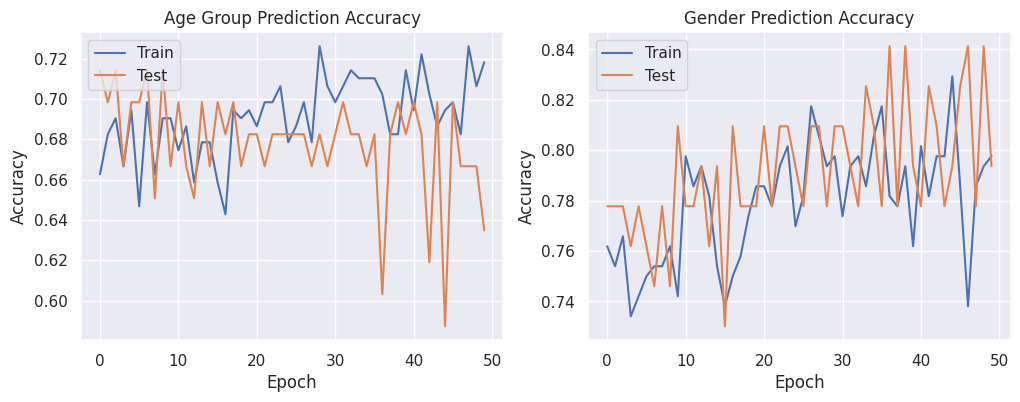

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_accuracy'])
plt.plot(history.history['val_age_output_accuracy'])
plt.title('Age Group Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Prediction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
import joblib
from tensorflow.keras.models import load_model

# Save the model
model.save("my_model.h5")

In [ ]:
# Save the encoders
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import LabelEncoder

import joblib

# Save the encoders
joblib.dump(age_encoder, "age_encoder.pkl")
joblib.dump(gender_encoder, "gender_encoder.pkl")


# 10 Chargement du Modèle et des Encodeurs, Extraction des Caractéristiques Audio, et Prédiction de l'Âge et du Genre

In [ ]:
import warnings
import pandas as pd
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import LabelEncoder

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the saved model
loaded_model = load_model("my_model.h5")

# Load the encoders
age_encoder = joblib.load("age_encoder.pkl")
gender_encoder = joblib.load("gender_encoder.pkl")

# Define a function to extract features from a single audio file
def extract_features_from_audio(file_path):
    audio_data, sampling_rate = librosa.load(file_path)
    features = []
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sampling_rate))
    features.extend([spectral_centroid, spectral_bandwidth, spectral_rolloff])

    mfcc = librosa.feature.mfcc(y=audio_data, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))

    return np.array(features)

# Define a function to map numeric predictions to original labels
def map_labels(age_prediction, gender_prediction, age_encoder, gender_encoder):
    age_label = age_encoder.inverse_transform([age_prediction])[0]
    gender_label = gender_encoder.inverse_transform([gender_prediction])[0]
    return age_label, gender_label

# Define a function to predict age group and gender from an audio file
def predict_age_gender(file_path, model, age_encoder, gender_encoder):
    # Extract features from the audio file
    features = extract_features_from_audio(file_path)
    # Reshape features for LSTM model input
    features = features.reshape(1, features.shape[0], 1)
    # Make predictions
    predictions = model.predict(features)
    age_prob, gender_prob = predictions[0], predictions[1]
    # Decode predictions
    age_prediction = np.argmax(age_prob)
    gender_prediction = np.argmax(gender_prob)
    # Map numeric predictions to original labels
    age_label, gender_label = map_labels(age_prediction, gender_prediction, age_encoder, gender_encoder)
    return age_label, gender_label




In [ ]:
from IPython.display import Audio

file_path = "/content/drive/MyDrive/Vocal/Pred/23-me d’Habib.m4a"
Audio(file_path)


In [ ]:
# Usage example
file_path = "/content/drive/MyDrive/Vocal/Pred/23-me d’Habib.m4a"
age_label, gender_label = predict_age_gender(file_path, loaded_model, age_encoder, gender_encoder)
print("Predicted Age Group:", age_label)
print("Predicted Gender:", gender_label)

1/1 [==============================] - 1s 850ms/step
Predicted Age Group: twenties
Predicted Gender: female


In [ ]:
file_paths = [
    "/content/drive/MyDrive/Vocal/Pred/33-5al.m4a",
    "/content/drive/MyDrive/Vocal/Pred/24-voudel.m4a"
    "/content/drive/MyDrive/Vocal/audio_128_audio_043_24_11.m4a"
]

# Play each audio file
for file_path in file_paths:
    display(Audio(file_paths))

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:

file_paths = [
    "/content/drive/MyDrive/Vocal/Pred/33-5al.m4a",
    "/content/drive/MyDrive/Vocal/Pred/24-voudel.m4a"
]

# Iterate over each file path and predict age and gender
for file_path in file_paths:
    age_label, gender_label = predict_age_gender(file_path, loaded_model, age_encoder, gender_encoder)
    print(f"File: {file_path}")
    print(f"Predicted Age Group: {age_label}")
    print(f"Predicted Gender: {gender_label}\n")


In [ ]:
from IPython.display import display, Audio

file_paths = [
    "/content/drive/MyDrive/Vocal/Pred/dd.m4a",
    "/content/drive/MyDrive/Vocal/Pred/bekar.m4a",
    "/content/drive/MyDrive/Vocal/Pred/Zeynebou.m4a",
    "/content/drive/MyDrive/Vocal/Pred/24-voudel.m4a",
    "/content/drive/MyDrive/Vocal/Pred/da3iye.m4a"
]

for file_path in file_paths:
    try:
        # Affichage et lecture du fichier audio
        display(Audio(file_path))
    except ValueError as e:
        print(f"Error playing file {file_path}: {e}")
        continue

    try:
        # Prédiction de l'âge et du sexe
        age_label, gender_label = predict_age_gender(file_path, loaded_model, age_encoder, gender_encoder)
        print(f"File: {file_path}")
        print(f"Predicted Age Group: {age_label}")
        print(f"Predicted Gender: {gender_label}\n")
    except Exception as e:
        print(f"Error predicting for file {file_path}: {e}")


1/1 [==============================] - 0s 35ms/step
File: /content/drive/MyDrive/Vocal/Pred/21_facebook.m4a
Predicted Age Group: twenties
Predicted Gender: female



1/1 [==============================] - 0s 39ms/step
File: /content/drive/MyDrive/Vocal/Pred/tante.m4a
Predicted Age Group: thirties
Predicted Gender: female



1/1 [==============================] - 0s 43ms/step
File: /content/drive/MyDrive/Vocal/Pred/24-voudel.m4a
Predicted Age Group: thirties
Predicted Gender: female

